In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:20]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [ ]:
import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>20:
        return [],[],[],[],[],[]
    ecg_rr[np.isnan(ecg_rr)] = 0
    m = np.nanmean(ecg_rr[ecg_rr>0])
    s = np.nanmean(ecg_rr[ecg_rr>0])
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<50:
            continue
        index = np.isnan(ppg_rr)
        ppg_qual[index] = -1
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        tmp[np.isnan(tmp[:,0]),0] = np.nanmean(tmp[~np.isnan(tmp[:,0]),0])
        tmp[tmp[:,0]==0,0] = np.mean(tmp[tmp[:,0]>0,0])
        tmp[np.isnan(tmp)] = 0
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
    return X,y,ecg,means,stds,quals

unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return []
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col
# for user in unique_users:
#     data_user = data_all[data_all.user.isin([user])]
all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

In [ ]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])

In [ ]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals],open('../data_users/processed_data.p','wb'),protocol=4)

In [35]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals = pickle.load(open('../data_users/processed_data.p','rb'))

In [36]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals)

In [37]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute,Conv1D,Dropout,BatchNormalization
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU,MaxPool1D,concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([0,4,8,1,5,8,2,6,8,3,7,8,8])], y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X_train.shape,y_test.shape,y_val.shape,means_val.shape,stds_val.shape)

(32330, 60, 13) (19905, 60) (8083, 60) (8083, 1) (8083, 1)


In [96]:
timesteps = 60
input_dim = 13
latent_dim = 20
output_dim = 1
n = 1
input_shape = (timesteps,input_dim)
act = 'relu'

def get_attention(input_1,timesteps):
#     encoded = Bidirectional(GRU(timesteps,return_sequences=True,activation='relu',go_backwards=True))(input_1)
    encoded = Conv1D(timesteps*2,10,input_shape=input_shape,activation=act,kernel_initializer='normal',padding='same')(input_1)
    encoded = BatchNormalization()(encoded)
    att = Dense(1,activation='relu')(encoded)
    att = Flatten()(att)
    att1 = Activation(activation="softmax")(att)
    att = RepeatVector(timesteps*2)(att1)
    att = Permute((2,1))(att)
    mer = multiply([att, encoded])
    return mer,Reshape((timesteps,1))(att1)

def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)
    
    
inputs = Input(shape=input_shape)
# input_best = crop(2,0,3)(inputs)
input_red = crop(2,3,6)(inputs)
input_ir = crop(2,6,9)(inputs)
input_green = crop(2,9,12)(inputs)
motion = crop(2,12,13)(inputs)

# output_best,at_best = get_attention(input_best,timesteps)
output_red,at_red = get_attention(input_red,timesteps)
output_ir,at_ir = get_attention(input_ir,timesteps)
output_green,at_green = get_attention(input_green,timesteps)

at_all = concatenate([at_red,at_ir,at_green],name='attention')
output_all = concatenate([output_red,output_ir,output_green],name='output')
# encoded = Bidirectional(GRU(timesteps//4,return_sequences=True,activation='relu',go_backwards=True))(output_all)
encoded = Conv1D(timesteps,10,input_shape=input_shape,activation=act,kernel_initializer='normal',padding='same')(output_all)
encoded = BatchNormalization()(encoded)
encoded = Conv1D(timesteps,10,input_shape=input_shape,activation=act,kernel_initializer='normal',padding='same')(encoded)

att = Dense(1,activation='relu')(at_all)
att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(timesteps)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])
mer = Bidirectional(GRU(10,return_sequences=True,activation='relu',go_backwards=True))(mer)
mer = Dense(1,activation='relu')(mer)
mer = Flatten()(mer)
# mer = Flatten()(mer)
# mer = Dense(120,activation='relu',name='sequence1')(mer)
# mer = Dense(60,activation='relu',name='sequence2')(mer)
mer = Dense(30,activation='relu',name='sequence3')(mer)
mer = Dense(60,activation='relu',name='sequence')(mer)
sequence_autoencoder = Model(inputs=[inputs], outputs=[mer])
sequence_autoencoder.compile(optimizer='adam',loss='logcosh',metrics=['mae'])
sequence_autoencoder.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 60, 13)       0                                            
__________________________________________________________________________________________________
lambda_165 (Lambda)             (None, 60, 3)        0           input_39[0][0]                   
__________________________________________________________________________________________________
lambda_166 (Lambda)             (None, 60, 3)        0           input_39[0][0]                   
__________________________________________________________________________________________________
lambda_167 (Lambda)             (None, 60, 3)        0           input_39[0][0]                   
___________________________________________________________________________________________

In [97]:
filepath = '../models/base_LSTM_attention_divided.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, y_train,
                epochs=300,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,y_val),callbacks=callbacks_list)

Train on 32330 samples, validate on 8083 samples
Epoch 1/300
32330/32330 [==============================] - 16s 488us/step - loss: 728.8353 - mae: 729.5284 - val_loss: 440.2899 - val_mae: 440.9824

Epoch 00001: val_loss improved from inf to 440.28993, saving model to ../models/base_LSTM_attention_divided.hdf5
Epoch 2/300
32330/32330 [==============================] - 14s 436us/step - loss: 371.5129 - mae: 372.2047 - val_loss: 662.4927 - val_mae: 663.1859

Epoch 00002: val_loss did not improve from 440.28993
Epoch 3/300
32330/32330 [==============================] - 13s 402us/step - loss: 354.5115 - mae: 355.2032 - val_loss: 423.3235 - val_mae: 424.0162

Epoch 00003: val_loss improved from 440.28993 to 423.32350, saving model to ../models/base_LSTM_attention_divided.hdf5
Epoch 4/300
32330/32330 [==============================] - 13s 405us/step - loss: 354.4521 - mae: 355.1437 - val_loss: 376.8546 - val_mae: 377.5471

Epoch 00004: val_loss improved from 423.32350 to 376.85458, saving mod

KeyboardInterrupt: 

In [98]:
from keras.models import load_model
import tensorflow_probability as tfp
filepath = '../models/base_LSTM_attention_divided.hdf5'
sequence_autoencoder = load_model(filepath)

In [99]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1
mean_pred = y_pred1[1]
stds_pred = y_pred1[2]

In [100]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((60,), (60,), (60,))

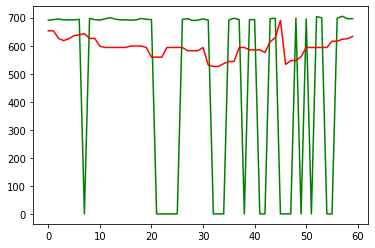

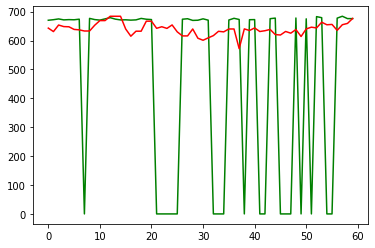

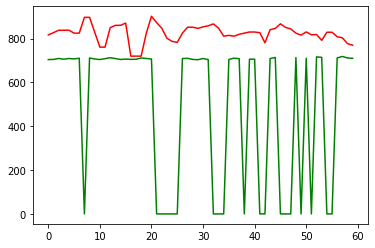

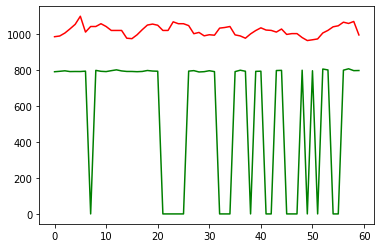

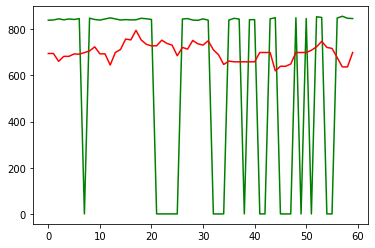

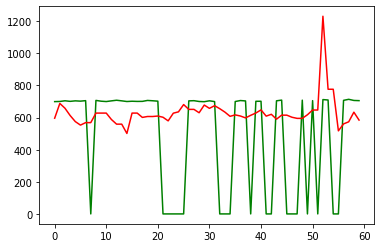

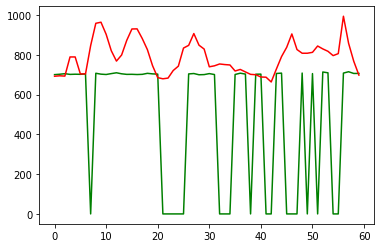

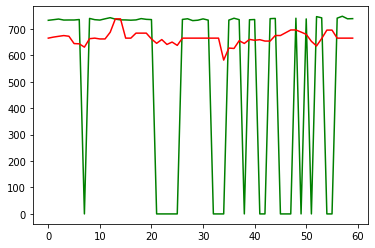

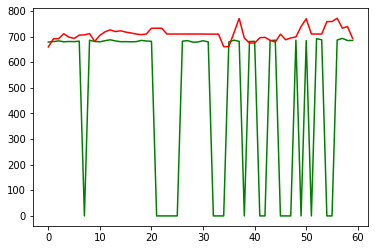

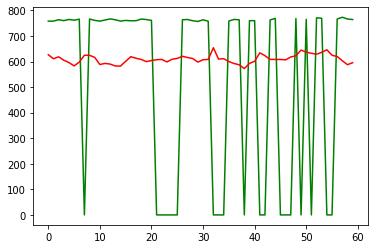

In [101]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[:10]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#         plt.plot(X[i,:,:],'r')
#     plt.plot(y_test[i],'b')
    plt.plot(ecg_test[i],'r')
    plt.show()

In [102]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [103]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]
# X = X[X[:,1]>0]
X.shape

(1191721, 4)

(array([438437., 163388.,  93857.,  75996.,  67091.,  60504.,  55083.,
         54216.,  57158., 125991.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

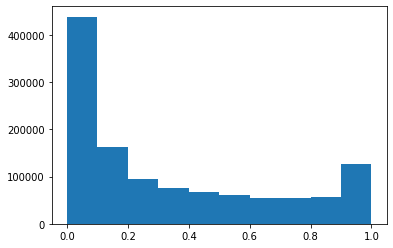

In [104]:
plt.hist(X[:,0])

(264835, 4) 0.0
(173602, 4) 0.05
(98798, 4) 0.1
(64590, 4) 0.15000000000000002
(50627, 4) 0.2
(42667, 4) 0.25
(39278, 4) 0.30000000000000004
(36718, 4) 0.35000000000000003
(34528, 4) 0.4
(32563, 4) 0.45
(31123, 4) 0.5
(29381, 4) 0.55
(27820, 4) 0.6000000000000001
(27648, 4) 0.65
(27029, 4) 0.7000000000000001
(27583, 4) 0.75
(28646, 4) 0.8
(29266, 4) 0.8500000000000001
(35209, 4) 0.9
(65564, 4) 0.9500000000000001
20 20


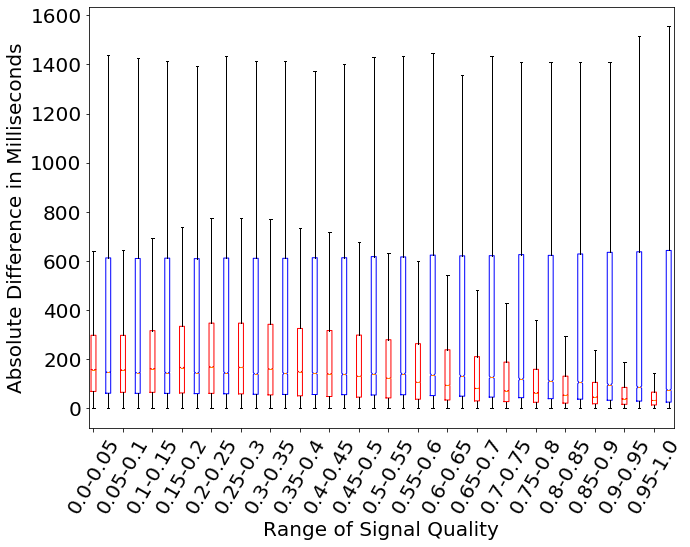

In [105]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'range_nni'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(np.array(list(get_time_domain_features(y_pred_min).values())))
    y.append(np.array(list(get_time_domain_features(ecg_min).values())))
    z.append(np.array(list(get_time_domain_features(y_test_min).values())))
    q.append(np.median(qual_min))
#     if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
#         x = x[:-1]
#         y= y[:-1]
#         z= z[:-1]
#         q= q[:-1]
#     elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
#         x = x[:-1]
#         y= y[:-1]
#         z= z[:-1]
#         q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
x,y,z,q = np.array(x),np.array(y),np.array(z),np.array(z)

In [ ]:
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
quality_col = ['median']

In [ ]:
for i,f in enumerate(feature_col):
    ecg_i = y[:,i]
    x_i = x[:,i]
    diffs = np.abs(ecg_i-x_i)
    plt.figure()
    plt.plot(q,diffs)
    plt.show()
    print(mean_absolute_error(ecg_i,x_i))

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score
%matplotlib inline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
def aic(X,y):
    regr = OLS(y, add_constant(X)).fit()
    return regr.aic

# from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100

def output(quality,features_ecg,features1,j,q_name):
    
    for i,f_name in enumerate(feature_col):
        features = features1[:,i]
        ground_truth = features_ecg[:,i]
        qual = quality[:,j]
#         output(quals,input_ecg,input_ppg,f_name,q_name)
    
        l_range = np.arange(0,1,.1)
        x = []
        y = []
        for l in l_range:
            index = np.where((qual>=l)&(qual<l+.1))[0]
            if len(index)<2:
                continue
            temp_input = features[index]
            temp_output = ground_truth[index]
            x.append(l)
    #         y.append(aic(temp_input,temp_output))
            y.append(pearsonr(temp_output,temp_input)[0])
    #     plt.boxplot(y,showfliers=False)
        plt.figure(figsize=(10,8))
        plt.rcParams.update({'font.size':20})
        plt.bar(x,y,.05,label = str(f_name))
#         plt.plot(x,y,label = str(f_name) )
    #     plt.xticks(range(1,len(x)+1),x,rotation=60)
        plt.ylabel('Percentage Error')
        plt.xlabel('Range of Signal Quality-'+str(q_name))
        plt.tight_layout()
        plt.legend()
        plt.show()

In [ ]:
for j,q_name in enumerate(quality_col):
    output(q,x,y,j,q_name)

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability